In [1]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import seaborn as sns

from models.vgg import VGG
from models.densenet import DenseNet3
from models.wideresnet import WideResNet
from utils.ood_metrics import tpr95, detection
from utils.datasets import GaussianNoise, UniformNoise

## ハイパーパラメータの設定

In [2]:
'''
ind_dataset = cifar10
ood_dataset = tinyImageNet_resize
model = vgg13
process = confidence
'''
batch_size =128
T = 1000.
epsilon = 0.001
filename = 'checkpoints/cifar10_vgg13_budget_0.3_seed_0'
validation = False
cudnn.benchmark = True  # Should make training should go faster for large models

## 正規化の前処理

In [3]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform = transforms.Compose([transforms.ToTensor(), normalize])

## in-distributionはCIFAR10<br>out-of-distributionはImagenet_resize

In [4]:
num_classes = 10
ind_dataset = datasets.CIFAR10(root='data/', train=False, transform=transform, download=True)
ood_dataset = datasets.ImageFolder(root='data/Imagenet_resize', transform=transform)

Files already downloaded and verified


In [5]:
test = datasets.ImageFolder(root='data/Imagenet_resize', transform=transforms.Compose([transforms.ToTensor()]))
img, lab = test[33]

## Imagenet_resizeの画像を見てみる

(-0.5, 31.5, 31.5, -0.5)

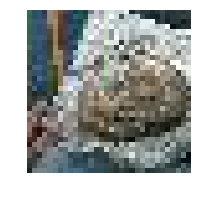

In [6]:
%matplotlib inline

def imshow(img):
    # unnormalize [-1, 1] => [0, 1]
    #img = img / 2 + 0.5
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.figure(figsize=(3,3))
imshow(make_grid(img))
plt.axis('off')

## データローダー

In [7]:
ind_loader = torch.utils.data.DataLoader(
                                         dataset=ind_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

ood_loader = torch.utils.data.DataLoader(
                                         dataset=ood_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

# Use remaining samples for test evaluation
ood_loader.dataset.imgs = ood_loader.dataset.imgs[1000:]
ood_loader.dataset.__len__ = len(ood_loader.dataset.imgs)

## モデルはVGG13＋学習した重みをロード

In [8]:
cnn = VGG(vgg_name='VGG13', num_classes=num_classes).cuda()
model_dict = cnn.state_dict()
pretrained_dict = torch.load(filename + '.pt')
cnn.load_state_dict(pretrained_dict)
cnn = cnn.cuda()
cnn.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [24]:
data_iter = iter(ind_loader)
images, labels = data_iter.next()

In [25]:
images = Variable(images, requires_grad=True).cuda()
prediction, confidence = cnn(images)

In [26]:
confidence.shape

torch.Size([128, 1])

In [27]:
# 最終層の活性化
pred_original = F.softmax(prediction, dim=-1)
confidence = F.sigmoid(confidence)

/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [28]:
confidence

tensor([[0.8413],
        [0.7855],
        [0.4223],
        [0.3229],
        [0.9504],
        [0.7313],
        [0.7509],
        [0.6937],
        [0.8718],
        [0.8501],
        [0.8419],
        [0.9657],
        [0.7512],
        [0.9822],
        [0.9834],
        [0.2472],
        [0.9865],
        [0.7856],
        [0.9376],
        [0.8467],
        [0.1475],
        [0.2287],
        [0.7625],
        [0.9601],
        [0.4784],
        [0.6039],
        [0.6829],
        [0.9738],
        [0.9062],
        [0.9366],
        [0.8901],
        [0.9389],
        [0.3777],
        [0.7024],
        [0.9798],
        [0.2202],
        [0.5849],
        [0.7535],
        [0.9286],
        [0.9945],
        [0.9719],
        [0.9069],
        [0.2055],
        [0.9007],
        [0.9588],
        [0.9802],
        [0.3751],
        [0.1861],
        [0.9289],
        [0.4453],
        [0.9247],
        [0.8737],
        [0.2837],
        [0.5722],
        [0.9119],
        [0

In [29]:
# clampメソッドで数値を範囲内に収める
eps = 1e-12
pred_original = torch.clamp(pred_original, 0. + eps, 1. - eps)
confidence = torch.clamp(confidence, 0. + eps, 1. - eps)

In [30]:
confidence

tensor([[0.8413],
        [0.7855],
        [0.4223],
        [0.3229],
        [0.9504],
        [0.7313],
        [0.7509],
        [0.6937],
        [0.8718],
        [0.8501],
        [0.8419],
        [0.9657],
        [0.7512],
        [0.9822],
        [0.9834],
        [0.2472],
        [0.9865],
        [0.7856],
        [0.9376],
        [0.8467],
        [0.1475],
        [0.2287],
        [0.7625],
        [0.9601],
        [0.4784],
        [0.6039],
        [0.6829],
        [0.9738],
        [0.9062],
        [0.9366],
        [0.8901],
        [0.9389],
        [0.3777],
        [0.7024],
        [0.9798],
        [0.2202],
        [0.5849],
        [0.7535],
        [0.9286],
        [0.9945],
        [0.9719],
        [0.9069],
        [0.2055],
        [0.9007],
        [0.9588],
        [0.9802],
        [0.3751],
        [0.1861],
        [0.9289],
        [0.4453],
        [0.9247],
        [0.8737],
        [0.2837],
        [0.5722],
        [0.9119],
        [0

In [36]:
# 予測値の補正を行う（ヒント部分）
# Randomly set half of the confidences to 1 (i.e. no hints)
b = Variable(torch.bernoulli(torch.Tensor(confidence.size()).uniform_(0, 1))).cuda()

In [37]:
conf = confidence * b + (1 - b)

In [41]:
from utils.utils import encode_onehot
labels = Variable(labels).cuda(async=True)
labels_onehot = Variable(encode_onehot(labels, num_classes))
# 予測を小さくして、正解ラベルの分布を足す
pred_new = pred_original * conf.expand_as(pred_original) + labels_onehot * (1 - conf.expand_as(labels_onehot))
pred_new = torch.log(pred_new)

In [45]:
# 損失計算
prediction_criterion = nn.NLLLoss().cuda()
xentropy_loss = prediction_criterion(pred_new, labels)
confidence_loss = torch.mean(-torch.log(confidence))

In [57]:
if 0.3 > confidence_loss.data[0]:
    print('yy')
else:
    print('nn')

nn


/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  """Entry point for launching an IPython kernel.


In [ ]:






# 損失を定義
total_loss = xentropy_loss + (lmbda * confidence_loss)
if budget > confidence_loss.data[0]:
    lmbda = lmbda / 1.01
elif budget <= confidence_loss.data[0]:
    lmbda = lmbda / 0.99